In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader
import time

In [2]:
start = time.time()
df = pd.read_csv('mmc2.csv', encoding = 'unicode_escape')

There are 11 independent variables and 5 dependent variables. Of the dependent variables, 1 is numeric (age), 8 are categorical with 2 levels (sex, family_status, genetic, status, loss_of_parent, divorce, injury, spiritual_consult) and 2 are categorical with more than 2 levels (religion, occupation). Age has been binned into categories (6-30, 31-50, 51-86), this variable is named agecode.

In [3]:
for col in df.columns:
    print(f'{col}: {df[col].sort_values().unique()}')

sex: ['F' 'M']
age: [ 6 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 70 72 73 74 76 86]
family_status: ['No' 'Yes']
religion: ['C' 'M' 'O']
occupation: ['ARTISAN' 'C/SERVANT' 'FORCE' 'RETIRED' 'STUDENT' 'UNEMPLYD']
genetic: ['No' 'Yes']
status: ['M' 'S']
loss_of_parent: ['No' 'Yes']
divorce: ['No' 'Yes']
injury: ['No' 'Yes']
spiritual_consult: ['No' 'Yes']
agecode: [1 2 3]
insomnia: ['N' 'P']
schizophrenia: ['N' 'P']
vascular_dementia: ['N' 'P']
adhd: ['N' 'P']
bipolar: ['N' 'P']


In [4]:
for val in df['agecode'].unique():
    print(f"Agecode: {val} => {df[df['agecode']==val]['age'].sort_values().unique()}")

Agecode: 1 => [ 6 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
Agecode: 2 => [31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50]
Agecode: 3 => [51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 70 72 73 74 76 86]


Categorical variables are encoded into numerical representations below

In [5]:
def binarize_col(colname, val1):
    df[colname] = df[colname].apply(lambda x:1 if x==val1 else 0)
    
for col,val in [('sex','M'),('family_status','Yes'),('genetic','Yes'),('status','S'),
                ('loss_of_parent','Yes'),('divorce','Yes'),('injury','Yes'),('spiritual_consult','Yes'),
                ('insomnia','P'),('schizophrenia','P'),('vascular_dementia','P'),('adhd','P'),('bipolar','P')]:
    binarize_col(col,val)
    
df['religion'] = df['religion'].replace({'C':1, 'M':2, 'O':3})
df['occupation'] = df['occupation'].replace({'ARTISAN':1, 'C/SERVANT':2,  'FORCE':3,
                                             'RETIRED':4, 'STUDENT':5, 'UNEMPLYD':6,})

Below are the unique values for each variable after encoding

In [6]:
for col in df.columns:
    print(f'{col}: {df[col].sort_values().unique()}')

sex: [0 1]
age: [ 6 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 70 72 73 74 76 86]
family_status: [0 1]
religion: [1 2 3]
occupation: [1 2 3 4 5 6]
genetic: [0 1]
status: [0 1]
loss_of_parent: [0 1]
divorce: [0 1]
injury: [0 1]
spiritual_consult: [0 1]
agecode: [1 2 3]
insomnia: [0 1]
schizophrenia: [0 1]
vascular_dementia: [0 1]
adhd: [0 1]
bipolar: [0 1]


Below is the correlation heatmap for the data

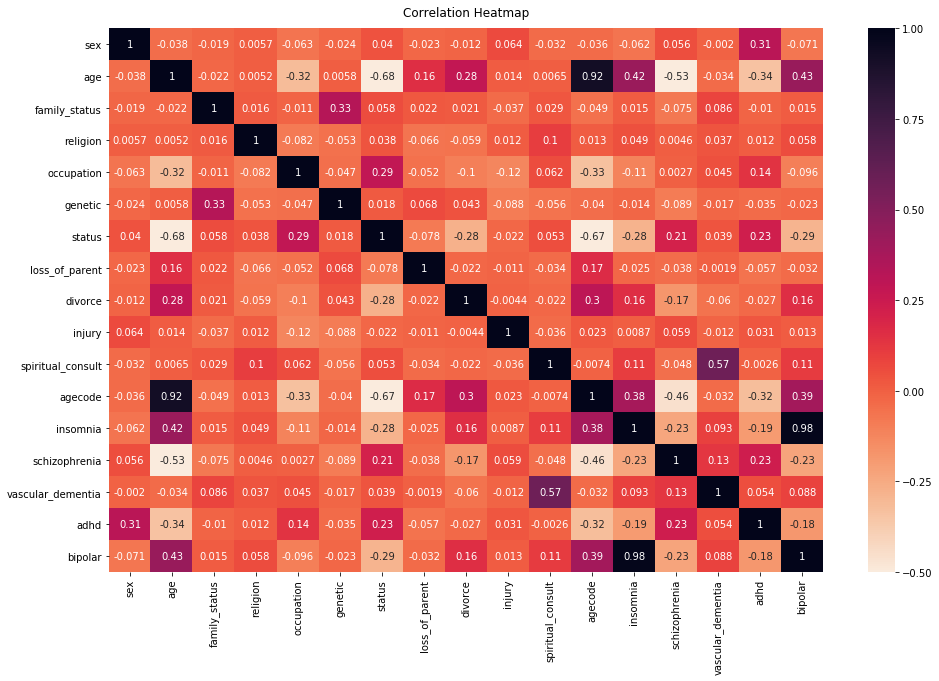

In [7]:
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(df.corr(), vmin=-0.5, vmax=1, annot=True, 
                      annot_kws={"size":10}, cmap='rocket_r')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# fix for mpl bug that cuts off top/bottom of seaborn viz
# https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!


Categorical variables with more than 2 levels are one-hot encoded. It's unclear from paper whether both age is dropped as a column since binned age is used, so I've kept both here

In [8]:
def onehot_encode(colname, df):
    return pd.concat([df.iloc[:,:-5], pd.get_dummies(df[colname], drop_first=True, prefix=colname[:3]),df.iloc[:,-5:]], axis=1).drop(columns=colname)
    
for col in ['occupation', 'religion']:
    df = onehot_encode(col, df)

Create disorder by concatenating values for each disorder

In [9]:
out_df = df.iloc[:,-5:].copy()
df['disorder'] = out_df.apply(lambda x:str(x.insomnia)+str(x.schizophrenia)+
                         str(x.vascular_dementia)+str(x.adhd)+str(x.bipolar), axis=1)

In [10]:
X = df.iloc[:,:-6]
Y = df['disorder']
Y_multi = df.iloc[:,-6:-1]
print('Class counts before SMOTE')
print(Y.value_counts().values)

# To apply SMOTE, first remove all low frequency combinations
vc = df['disorder'].value_counts()
vals_to_keep = vc[vc > 6].index.values
df_bal = df[df['disorder'].isin(vals_to_keep)]

X_bal_no_smote = df_bal.iloc[:,:-6]
Y_bal_no_smote = df_bal['disorder']
Y_bal_multi_no_smote = df_bal.iloc[:,-6:-1]
print('Class counts after dropping low frequency classes')
print(Y_bal_no_smote.value_counts().values)


# Apply SMOTE
oversample = SMOTE(random_state=100)

X_bal, Y_bal = oversample.fit_resample(X_bal_no_smote, Y_bal_no_smote)
Y_bal_multi = pd.DataFrame(Y_bal.copy())
for i, col in enumerate(df_bal.iloc[:,-6:-1].columns):
    Y_bal_multi[col] = Y_bal_multi['disorder'].apply(lambda x:int(x[i]))
Y_bal_multi.drop(columns=['disorder'], inplace=True)

print('Class counts after SMOTE')
print(Y_bal.value_counts().values)

Class counts before SMOTE
[101  81  72  48  47  43  23  21  19  10  10   9   5   3   2   2   2   1
   1]
Class counts after dropping low frequency classes
[101  81  72  48  47  43  23  21  19  10  10   9]
Class counts after SMOTE
[101 101 101 101 101 101 101 101 101 101 101 101]


Change disorder to code to help with classification

In [11]:
def encode(df, col):
    newcol = col + '_code'
    df[newcol] = 0
    for i,val in enumerate(df[col].unique()):
        df[newcol] = df.apply(lambda x:i if x[col]==val else x[newcol], axis=1)
    return df

In [12]:
df = encode(df.copy(),'disorder')
df_bal = encode(df_bal.copy(), 'disorder')

In [13]:
# Create test/train splits for both imbalanced and balanced data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state = 0)
Xb_train, Xb_test, Yb_train, Yb_test = train_test_split(X_bal, Y_bal, train_size=0.8, random_state = 0)

## Support Vector Machine

In [14]:
# SVM with class imbalance

for c in [0.01, 0.05, 0.1, 0.15, 1, 10, 100]:
    clf = svm.SVC(kernel='linear', C=c, decision_function_shape='ovo', random_state=0)
    clf.fit(X_train, Y_train)

    Y_pred = clf.predict(X_test)

    accuracy = clf.score(X_test, Y_test)
    print('C: {}, Accuracy Linear Kernel: {:.4f}'.format(c,accuracy))

C: 0.01, Accuracy Linear Kernel: 0.3300
C: 0.05, Accuracy Linear Kernel: 0.3700
C: 0.1, Accuracy Linear Kernel: 0.4500
C: 0.15, Accuracy Linear Kernel: 0.4600
C: 1, Accuracy Linear Kernel: 0.3600
C: 10, Accuracy Linear Kernel: 0.3400
C: 100, Accuracy Linear Kernel: 0.2900


For SVM with class imbalance, best accuracy of 0.46 is achieved for C=0.15

In [15]:
# SVM after SMOTE

for c in [0.01, 0.05, 0.1, 0.15, 1, 10, 100]:
    clf = svm.SVC(kernel='linear', C=c, decision_function_shape='ovo', random_state=0)
    clf.fit(Xb_train, Yb_train)

    Yb_pred = clf.predict(Xb_test)

    accuracy = clf.score(Xb_test, Yb_test)
    print('C: {}, Accuracy Linear Kernel: {:.4f}'.format(c,accuracy))

C: 0.01, Accuracy Linear Kernel: 0.3292
C: 0.05, Accuracy Linear Kernel: 0.4403
C: 0.1, Accuracy Linear Kernel: 0.4568
C: 0.15, Accuracy Linear Kernel: 0.5021
C: 1, Accuracy Linear Kernel: 0.5267
C: 10, Accuracy Linear Kernel: 0.5679
C: 100, Accuracy Linear Kernel: 0.5720


For SVM with balanced classes, best accuracy of 0.5720 is achieved for C=100

## Random Forest

In [16]:
# Random Forest with class imbalance
for n in [100,200,300]:
    for depth in range(2,8):
        clf = RandomForestClassifier(max_depth = depth, n_estimators = n, 
                                     criterion = 'entropy', random_state = 0)
        clf.fit(X_train, Y_train)

        Y_pred = clf.predict(X_test)

        accuracy = clf.score(X_test, Y_test)
        print(f'Number of Trees: {n}, Max Depth: {depth}, Accuracy Random Forest:, {accuracy:.4f}')

Number of Trees: 100, Max Depth: 2, Accuracy Random Forest:, 0.3000
Number of Trees: 100, Max Depth: 3, Accuracy Random Forest:, 0.3900
Number of Trees: 100, Max Depth: 4, Accuracy Random Forest:, 0.4100
Number of Trees: 100, Max Depth: 5, Accuracy Random Forest:, 0.4200
Number of Trees: 100, Max Depth: 6, Accuracy Random Forest:, 0.4200
Number of Trees: 100, Max Depth: 7, Accuracy Random Forest:, 0.3700
Number of Trees: 200, Max Depth: 2, Accuracy Random Forest:, 0.3000
Number of Trees: 200, Max Depth: 3, Accuracy Random Forest:, 0.4200
Number of Trees: 200, Max Depth: 4, Accuracy Random Forest:, 0.4300
Number of Trees: 200, Max Depth: 5, Accuracy Random Forest:, 0.4300
Number of Trees: 200, Max Depth: 6, Accuracy Random Forest:, 0.4100
Number of Trees: 200, Max Depth: 7, Accuracy Random Forest:, 0.3600
Number of Trees: 300, Max Depth: 2, Accuracy Random Forest:, 0.3100
Number of Trees: 300, Max Depth: 3, Accuracy Random Forest:, 0.3900
Number of Trees: 300, Max Depth: 4, Accuracy Ran

For Random Forest with imbalanced classes, best accuracy of 0.43 is achieved for n_estimators=200 and max_depth=4

In [17]:
# Random Forest after SMOTE
for n in [100,200,300]:
    for depth in range(2,10):
        clf = RandomForestClassifier(max_depth = depth, n_estimators = n, 
                                     criterion = 'entropy', random_state = 0)
        clf.fit(Xb_train, Yb_train)

        Yb_pred = clf.predict(Xb_test)

        accuracy = clf.score(Xb_test, Yb_test)
        print(f'Number of Trees: {n}, Max Depth: {depth}, Accuracy Random Forest:, {accuracy:.4f}')

Number of Trees: 100, Max Depth: 2, Accuracy Random Forest:, 0.3580
Number of Trees: 100, Max Depth: 3, Accuracy Random Forest:, 0.4239
Number of Trees: 100, Max Depth: 4, Accuracy Random Forest:, 0.4774
Number of Trees: 100, Max Depth: 5, Accuracy Random Forest:, 0.4979
Number of Trees: 100, Max Depth: 6, Accuracy Random Forest:, 0.5185
Number of Trees: 100, Max Depth: 7, Accuracy Random Forest:, 0.5844
Number of Trees: 100, Max Depth: 8, Accuracy Random Forest:, 0.6296
Number of Trees: 100, Max Depth: 9, Accuracy Random Forest:, 0.6543
Number of Trees: 200, Max Depth: 2, Accuracy Random Forest:, 0.3827
Number of Trees: 200, Max Depth: 3, Accuracy Random Forest:, 0.4280
Number of Trees: 200, Max Depth: 4, Accuracy Random Forest:, 0.4774
Number of Trees: 200, Max Depth: 5, Accuracy Random Forest:, 0.5062
Number of Trees: 200, Max Depth: 6, Accuracy Random Forest:, 0.5309
Number of Trees: 200, Max Depth: 7, Accuracy Random Forest:, 0.5926
Number of Trees: 200, Max Depth: 8, Accuracy Ran

For Random Forest with balanced classes, best accuracy of 0.6667 is achieved for n_estimators=200 and max_depth=9

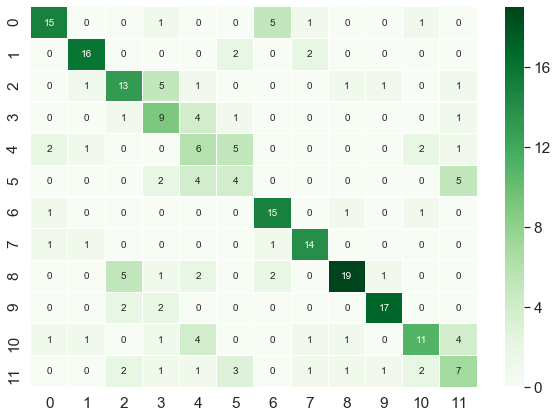

In [18]:
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth = 200, n_estimators = 9, 
                             criterion = 'entropy', random_state = 0)
clf.fit(Xb_train, Yb_train)
Yb_pred = clf.predict(Xb_test)

matrix = confusion_matrix(Yb_test, Yb_pred)

# Build the plot
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)


# fix for mpl bug that cuts off top/bottom of seaborn viz
# https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

## Decision Tree

In [19]:
# Decision Tree with class imbalance
for depth in range(2,10):
    clf = DecisionTreeClassifier(max_depth = depth, random_state=0)
    clf.fit(X_train, Y_train)

    Y_pred = clf.predict(X_test)

    accuracy = clf.score(X_test, Y_test)
    print(f'Max Depth: {depth}, Accuracy Decision Tree:, {accuracy:.4f}')

Max Depth: 2, Accuracy Decision Tree:, 0.3900
Max Depth: 3, Accuracy Decision Tree:, 0.4600
Max Depth: 4, Accuracy Decision Tree:, 0.4800
Max Depth: 5, Accuracy Decision Tree:, 0.3700
Max Depth: 6, Accuracy Decision Tree:, 0.3500
Max Depth: 7, Accuracy Decision Tree:, 0.3500
Max Depth: 8, Accuracy Decision Tree:, 0.3100
Max Depth: 9, Accuracy Decision Tree:, 0.2600


For Decision Tree with imbalanced classes, best accuracy of 0.48 is achieved for max_depth=4

In [20]:
# Decision Tree after SMOTE
for depth in range(2,25):
    clf = DecisionTreeClassifier(max_depth = depth, random_state=0)
    clf.fit(Xb_train, Yb_train)

    Yb_pred = clf.predict(Xb_test)

    accuracy = clf.score(Xb_test, Yb_test)
    print(f'Max Depth: {depth}, Accuracy Decision Tree:, {accuracy:.4f}')

Max Depth: 2, Accuracy Decision Tree:, 0.2222
Max Depth: 3, Accuracy Decision Tree:, 0.3827
Max Depth: 4, Accuracy Decision Tree:, 0.4609
Max Depth: 5, Accuracy Decision Tree:, 0.4897
Max Depth: 6, Accuracy Decision Tree:, 0.5185
Max Depth: 7, Accuracy Decision Tree:, 0.5309
Max Depth: 8, Accuracy Decision Tree:, 0.5720
Max Depth: 9, Accuracy Decision Tree:, 0.5844
Max Depth: 10, Accuracy Decision Tree:, 0.6008
Max Depth: 11, Accuracy Decision Tree:, 0.6091
Max Depth: 12, Accuracy Decision Tree:, 0.6132
Max Depth: 13, Accuracy Decision Tree:, 0.6296
Max Depth: 14, Accuracy Decision Tree:, 0.6173
Max Depth: 15, Accuracy Decision Tree:, 0.6173
Max Depth: 16, Accuracy Decision Tree:, 0.6132
Max Depth: 17, Accuracy Decision Tree:, 0.6255
Max Depth: 18, Accuracy Decision Tree:, 0.6255
Max Depth: 19, Accuracy Decision Tree:, 0.6255
Max Depth: 20, Accuracy Decision Tree:, 0.6255
Max Depth: 21, Accuracy Decision Tree:, 0.6255
Max Depth: 22, Accuracy Decision Tree:, 0.6255
Max Depth: 23, Accura

For Decision Tree with imbalanced classes, best accuracy of 0.6296 is achieved for max_depth=13

## XGBoost

In [21]:
# XGBoost with imbalanced classes

for n in [10,25,50,100]:
    for depth in range(2,6):
        clf = XGBClassifier(max_depth = depth, n_estimators = n, random_state = 0)
        clf.fit(X_train, Y_train)

        Y_pred = clf.predict(X_test)

        accuracy = clf.score(X_test, Y_test)
        print(f'Number of Trees: {n}, Max Depth: {depth}, Accuracy XGBoost:, {accuracy:.4f}')

Number of Trees: 10, Max Depth: 2, Accuracy XGBoost:, 0.4500
Number of Trees: 10, Max Depth: 3, Accuracy XGBoost:, 0.4600
Number of Trees: 10, Max Depth: 4, Accuracy XGBoost:, 0.4500
Number of Trees: 10, Max Depth: 5, Accuracy XGBoost:, 0.4200
Number of Trees: 25, Max Depth: 2, Accuracy XGBoost:, 0.4600
Number of Trees: 25, Max Depth: 3, Accuracy XGBoost:, 0.4700
Number of Trees: 25, Max Depth: 4, Accuracy XGBoost:, 0.4200
Number of Trees: 25, Max Depth: 5, Accuracy XGBoost:, 0.4100
Number of Trees: 50, Max Depth: 2, Accuracy XGBoost:, 0.4400
Number of Trees: 50, Max Depth: 3, Accuracy XGBoost:, 0.3800
Number of Trees: 50, Max Depth: 4, Accuracy XGBoost:, 0.3600
Number of Trees: 50, Max Depth: 5, Accuracy XGBoost:, 0.3500
Number of Trees: 100, Max Depth: 2, Accuracy XGBoost:, 0.4200
Number of Trees: 100, Max Depth: 3, Accuracy XGBoost:, 0.3600
Number of Trees: 100, Max Depth: 4, Accuracy XGBoost:, 0.3600
Number of Trees: 100, Max Depth: 5, Accuracy XGBoost:, 0.3300


For XGBoost with imbalanced classes, best accuracy of 0.47 is achieved for n_estimators=25 and max_depth=3

In [22]:
# XGBoost after SMOTE
for n in [50,100,200]:
    for depth in range(2,8):
        clf = XGBClassifier(max_depth = depth, n_estimators = n, random_state = 0)
        clf.fit(Xb_train, Yb_train)

        Yb_pred = clf.predict(Xb_test)

        accuracy = clf.score(Xb_test, Yb_test)
        print(f'Number of Trees: {n}, Max Depth: {depth}, Accuracy XGBoost:, {accuracy:.4f}')

Number of Trees: 50, Max Depth: 2, Accuracy XGBoost:, 0.5062
Number of Trees: 50, Max Depth: 3, Accuracy XGBoost:, 0.5638
Number of Trees: 50, Max Depth: 4, Accuracy XGBoost:, 0.6214
Number of Trees: 50, Max Depth: 5, Accuracy XGBoost:, 0.6790
Number of Trees: 50, Max Depth: 6, Accuracy XGBoost:, 0.6749
Number of Trees: 50, Max Depth: 7, Accuracy XGBoost:, 0.6667
Number of Trees: 100, Max Depth: 2, Accuracy XGBoost:, 0.5597
Number of Trees: 100, Max Depth: 3, Accuracy XGBoost:, 0.6420
Number of Trees: 100, Max Depth: 4, Accuracy XGBoost:, 0.6584
Number of Trees: 100, Max Depth: 5, Accuracy XGBoost:, 0.6626
Number of Trees: 100, Max Depth: 6, Accuracy XGBoost:, 0.6872
Number of Trees: 100, Max Depth: 7, Accuracy XGBoost:, 0.6872
Number of Trees: 200, Max Depth: 2, Accuracy XGBoost:, 0.5802
Number of Trees: 200, Max Depth: 3, Accuracy XGBoost:, 0.6543
Number of Trees: 200, Max Depth: 4, Accuracy XGBoost:, 0.7119
Number of Trees: 200, Max Depth: 5, Accuracy XGBoost:, 0.6955
Number of Tree

For XGBoost with imbalanced classes, best accuracy of 0.7119 is achieved for n_estimators=200 and max_depth=4

## MLP Classfier

In [23]:
# MLP multi-class classifier with class imbalance
clf = MLPClassifier(random_state=0, 
                    activation = 'relu',solver='adam',max_iter=100,
                    warm_start=True,learning_rate_init=0.01,
                    early_stopping=True)
clf.fit(X_train.values, Y_train)
Yb_pred = clf.predict(X_test.values)
accuracy = clf.score(X_test.values,Y_test)
print(f'Accuracy MLP Classifier: {accuracy:.4f}')

Accuracy MLP Classifier: 0.2100


In [24]:
# MLP multi-output classifier with class imbalance
xtrain, xtest, ytrain, ytest = train_test_split(X, Y_multi, train_size=0.8, random_state = 0)
clf = MultiOutputClassifier(MLPClassifier(random_state=0, 
                            activation = 'relu',solver='adam',max_iter=100,
                            warm_start=True,learning_rate_init=0.01,
                            early_stopping=True))
clf.fit(xtrain.values, ytrain.values)
pred = clf.predict(xtest.values)
accuracy = clf.score(xtest.values,ytest.values)
mean_accuracy = accuracy_score(pred.reshape(-1,1),ytest.values.reshape(-1,1))
print(f'Accuracy MLP Classifier: {accuracy:.4f}')
print(f'Mean Accuracy MLP Classifier: {mean_accuracy:.4f}')

Accuracy MLP Classifier: 0.2500
Mean Accuracy MLP Classifier: 0.7360


In [25]:
# MLP for each class with imbalanced classes
xtrain, xtest, ytrain, ytest = train_test_split(X, Y_multi, train_size=0.8, random_state = 0)
for col in Y_multi.columns:
    clf = MLPClassifier(random_state=0, 
                        activation = 'relu',solver='adam',max_iter=100,
                        warm_start=True,learning_rate_init=0.01,
                        early_stopping=True)
    clf.fit(xtrain.values, ytrain[col].values)
    Yb_pred = clf.predict(xtest.values)
    accuracy = clf.score(xtest.values,ytest[col].values)
    print(f'Accuracy MLP Classifier for {col}: {accuracy:.4f}')

Accuracy MLP Classifier for insomnia: 0.7000
Accuracy MLP Classifier for schizophrenia: 0.9200
Accuracy MLP Classifier for vascular_dementia: 0.6600
Accuracy MLP Classifier for adhd: 0.6900
Accuracy MLP Classifier for bipolar: 0.7100


In [26]:
# MLP multi-class classifier after SMOTE
clf = MLPClassifier(random_state=0, 
                    activation = 'relu',solver='adam',max_iter=100,
                    warm_start=True,learning_rate_init=0.01,
                    early_stopping=True)
clf.fit(Xb_train.values, Yb_train.values)
Yb_pred = clf.predict(Xb_test.values)
accuracy = clf.score(Xb_test.values,Yb_test.values)
print(f'Accuracy MLP Classifier: {accuracy:.4f}')

Accuracy MLP Classifier: 0.4362


In [27]:
# MLP multi-output classifier after SMOTE
xtrain, xtest, ytrain, ytest = train_test_split(X_bal, Y_bal_multi, train_size=0.8, random_state = 0)
clf = MultiOutputClassifier(MLPClassifier(random_state=0, 
                            activation = 'relu',solver='adam',max_iter=100,
                            warm_start=True,learning_rate_init=0.01,
                            early_stopping=True))
clf.fit(xtrain.values, ytrain.values)
pred = clf.predict(xtest.values)
accuracy = clf.score(xtest.values,ytest.values)
mean_accuracy = accuracy_score(pred.reshape(-1,1),ytest.values.reshape(-1,1))
print(f'Accuracy MLP Classifier: {accuracy:.4f}')
print(f'Mean Accuracy MLP Classifier: {mean_accuracy:.4f}')

Accuracy MLP Classifier: 0.3786
Mean Accuracy MLP Classifier: 0.7523


In [28]:
# MLP for each class after SMOTE
X_train, X_test, Y_train, Y_test = train_test_split(X_bal, Y_bal_multi, train_size=0.8, random_state = 0)
for col in Y_multi.columns:
    clf = MLPClassifier(random_state=0, 
                        activation = 'relu',solver='adam',max_iter=100,
                        warm_start=True,learning_rate_init=0.01,
                        early_stopping=True)
    clf.fit(X_train.values, Y_train[col].values)
    Yb_pred = clf.predict(X_test.values)
    accuracy = clf.score(X_test.values,Y_test[col].values)
    print(f'Accuracy MLP Classifier for {col}: {accuracy:.4f}')

Accuracy MLP Classifier for insomnia: 0.6708
Accuracy MLP Classifier for schizophrenia: 0.8272
Accuracy MLP Classifier for vascular_dementia: 0.8066
Accuracy MLP Classifier for adhd: 0.7860
Accuracy MLP Classifier for bipolar: 0.6708


## Deep Learning Model

In [29]:
#defining dataset class
class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length

In [30]:
#defining the multi-output network
class MultiNet(nn.Module):
    def __init__(self,input_shape):
        super(MultiNet,self).__init__()
        self.fc1 = nn.Linear(input_shape,20)
        self.fc2 = nn.Linear(20,20)
        self.fc3 = nn.Linear(20,40)
        self.fc4 = nn.Linear(40,5)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc4(x))
        return x

In [31]:
#defining the network
class Net(nn.Module):
    def __init__(self,input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,20)
        self.fc2 = nn.Linear(20,40)
        self.fc3 = nn.Linear(40,50)
        self.fc4 = nn.Linear(50,1)
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [32]:
#feature scaling
sc = StandardScaler()
X = sc.fit_transform(X)
X_bal = sc.fit_transform(X_bal)

#hyper parameters
learning_rate = 0.01
loss_fn = nn.BCELoss()
epochs = 40

In [33]:
def train_model(xtest, ytest):
    #forward loop
    losses = []
    accur = []
    for i in range(1, epochs+1):
        for x_train,y_train in trainloader:

            #calculate output
            output = model(x_train)

            #calculate loss
            loss = loss_fn(output,y_train)

            #accuracy
            predicted = model(torch.tensor(xtest,dtype=torch.float32))
            if predicted.shape[1] ==1:
                predicted = predicted.reshape(-1)
            acc = accuracy_score(predicted.detach().numpy().round(),ytest)
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if i%10 == 0:
            losses.append(loss)
            accur.append(acc)
            print(f'epoch {i}\tloss : {loss}\t accuracy : {acc}')
            
    #plotting the loss
    plt.plot(range(1,epochs+1,10),losses)
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.show()

In [34]:
def evaluate_model(xtest, ytest):

    predicted = model(torch.tensor(xtest,dtype=torch.float32))
    if predicted.shape[1] ==1:
        predicted = predicted.reshape(-1)
    acc = accuracy_score(predicted.detach().numpy().round(),ytest)

    print(f'Final accuracy : {acc:.4f}')
    return acc

In [35]:
def evaluate_model_mean(xtest, ytest):

    predicted = model(torch.tensor(xtest,dtype=torch.float32))
    acc = accuracy_score(predicted.detach().numpy().round().reshape(-1,1),ytest.reshape(-1,1))

    print(f'Final mean accuracy : {acc:.4f}')
    return acc

epoch 10	loss : 0.4992651045322418	 accuracy : 0.26666666666666666
epoch 20	loss : 0.5701444745063782	 accuracy : 0.24666666666666667
epoch 30	loss : 0.48238563537597656	 accuracy : 0.29333333333333333
epoch 40	loss : 0.5511857271194458	 accuracy : 0.28


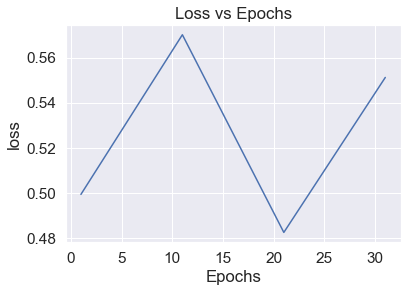

Final accuracy : 0.3743
Final accuracy : 0.3333
Final mean accuracy : 0.7863
Final mean accuracy : 0.7333


In [36]:
# Deep Learning multi-output classifier with class imbalance
df_results1 = pd.DataFrame()
xtrain, xtest, ytrain, ytest = train_test_split(X, Y_multi, train_size=0.7, random_state = 0)

trainset = dataset(xtrain,ytrain.values)
trainloader = DataLoader(trainset,batch_size=4,shuffle=False)

model = MultiNet(input_shape=X.shape[1])
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

train_model(xtest, ytest.values)
train_acc = evaluate_model(xtrain, ytrain.values)
test_acc = evaluate_model(xtest, ytest.values)

train_mean_acc = evaluate_model_mean(xtrain, ytrain.values)
test_mean_acc = evaluate_model_mean(xtest, ytest.values)

df_results1 = df_results1.append({'output': 'multi-output', 
                                'imb_train': train_acc, 
                                'imb_test': test_acc},
                                ignore_index=True)
                                
df_results1 = df_results1.append({'output': 'multi-output-mean',
                                'imb_train': train_mean_acc, 
                                'imb_test': test_mean_acc}, 
                                ignore_index=True)

insomnia
epoch 10	loss : 0.14422589540481567	 accuracy : 0.7133333333333334
epoch 20	loss : 0.2891337275505066	 accuracy : 0.6933333333333334
epoch 30	loss : 0.11523077636957169	 accuracy : 0.7066666666666667
epoch 40	loss : 0.2501338720321655	 accuracy : 0.6933333333333334


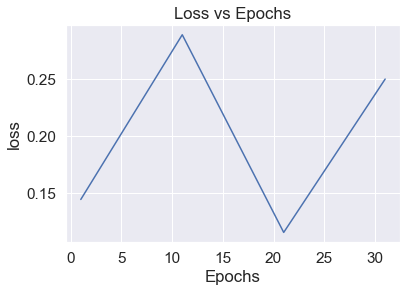

Final accuracy : 0.8229
Final accuracy : 0.6733
schizophrenia
epoch 10	loss : 1.0217723846435547	 accuracy : 0.8533333333333334
epoch 20	loss : 0.9795489311218262	 accuracy : 0.8933333333333333
epoch 30	loss : 0.7401251792907715	 accuracy : 0.9066666666666666
epoch 40	loss : 0.903417706489563	 accuracy : 0.8866666666666667


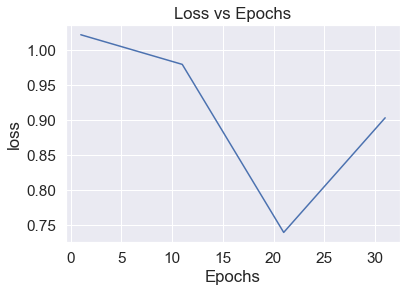

Final accuracy : 0.9486
Final accuracy : 0.9200
vascular_dementia
epoch 10	loss : 0.18423479795455933	 accuracy : 0.72
epoch 20	loss : 0.17982932925224304	 accuracy : 0.74
epoch 30	loss : 0.15307621657848358	 accuracy : 0.7133333333333334
epoch 40	loss : 0.28597015142440796	 accuracy : 0.7266666666666667


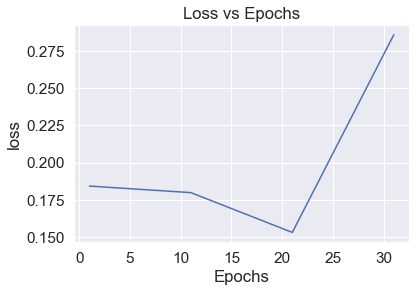

Final accuracy : 0.9114
Final accuracy : 0.7067
adhd
epoch 10	loss : 0.5087813138961792	 accuracy : 0.5866666666666667
epoch 20	loss : 0.31540295481681824	 accuracy : 0.5866666666666667
epoch 30	loss : 0.2952190339565277	 accuracy : 0.6066666666666667
epoch 40	loss : 0.7199209928512573	 accuracy : 0.5866666666666667


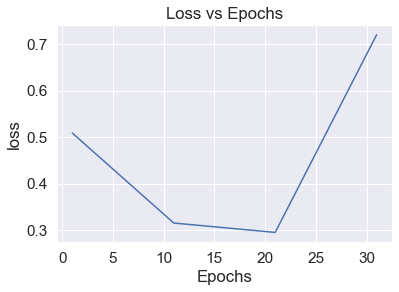

Final accuracy : 0.7971
Final accuracy : 0.6200
bipolar
epoch 10	loss : 0.3891632556915283	 accuracy : 0.6666666666666666
epoch 20	loss : 0.29949092864990234	 accuracy : 0.62
epoch 30	loss : 0.27095139026641846	 accuracy : 0.6533333333333333
epoch 40	loss : 0.1650792360305786	 accuracy : 0.6666666666666666


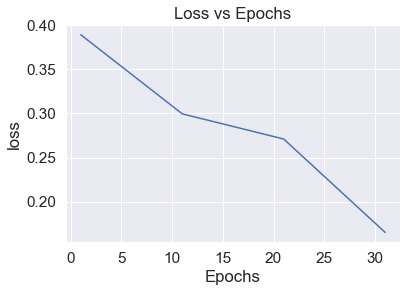

Final accuracy : 0.7971
Final accuracy : 0.6467


In [37]:
# MLP for each class with imbalanced classes
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_multi, train_size=0.7, random_state = 0)
model = Net(input_shape=X.shape[1])
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for col in Y_multi.columns:
    trainset = dataset(X_train,np.array(Y_train[col]).reshape(-1,1))
    trainloader = DataLoader(trainset,batch_size=4,shuffle=False)
    
    print(col)
    train_model(X_test, Y_test[col])
    train_acc = evaluate_model(X_train, Y_train[col])
    test_acc = evaluate_model(X_test, Y_test[col])
    df_results1 = df_results1.append({'output': col, 'imb_train': train_acc, 
                                      'imb_test': test_acc}, ignore_index=True)

In [38]:
df_results1

,imb_test,imb_train,output
0,0.333333,0.374286,multi-output
1,0.733333,0.786286,multi-output-mean
2,0.673333,0.822857,insomnia
3,0.920000,0.948571,schizophrenia
4,0.706667,0.911429,vascular_dementia
5,0.620000,0.797143,adhd
6,0.646667,0.797143,bipolar


epoch 10	loss : 0.5534805059432983	 accuracy : 0.3516483516483517
epoch 20	loss : 0.45825785398483276	 accuracy : 0.39285714285714285
epoch 30	loss : 0.44718295335769653	 accuracy : 0.40384615384615385
epoch 40	loss : 0.44095635414123535	 accuracy : 0.42857142857142855


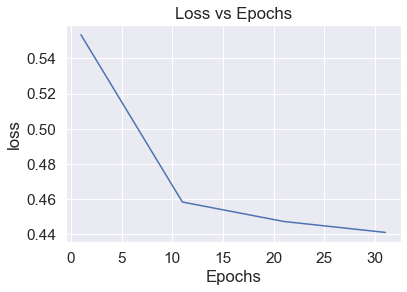

Final accuracy : 0.4599
Final accuracy : 0.4258
Final mean accuracy : 0.7884
Final mean accuracy : 0.7863


In [39]:
# Deep Learning multi-output classifier without class imbalance

df_results2 = pd.DataFrame()
xtrain, xtest, ytrain, ytest = train_test_split(X_bal, Y_bal_multi, train_size=0.7, random_state = 0)

trainset = dataset(xtrain,ytrain.values)
trainloader = DataLoader(trainset,batch_size=8,shuffle=False)

model = MultiNet(input_shape=X_bal.shape[1])
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

train_model(xtest, ytest.values)

train_acc = evaluate_model(xtrain, ytrain.values)
test_acc = evaluate_model(xtest, ytest.values)

train_mean_acc = evaluate_model_mean(xtrain, ytrain.values)
test_mean_acc = evaluate_model_mean(xtest, ytest.values)

df_results2 = df_results2.append({'output': 'multi-output', 
                                'bal_train': train_acc, 
                                'bal_test': test_acc},
                                ignore_index=True)
                                
df_results2 = df_results2.append({'output': 'multi-output-mean',
                                'bal_train': train_mean_acc, 
                                'bal_test': test_mean_acc}, 
                                ignore_index=True)

insomnia
epoch 10	loss : 0.0005251355469226837	 accuracy : 0.6790123456790124
epoch 20	loss : 0.0025557128246873617	 accuracy : 0.6954732510288066
epoch 30	loss : 0.0027939332649111748	 accuracy : 0.720164609053498
epoch 40	loss : 0.03447851538658142	 accuracy : 0.7654320987654321


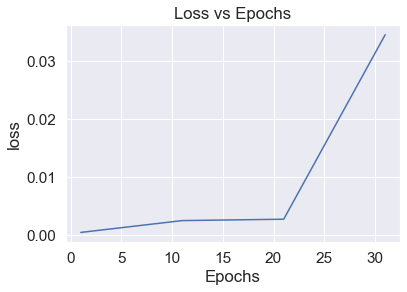

Final accuracy : 0.8050
Final accuracy : 0.7407
schizophrenia
epoch 10	loss : 0.289352148771286	 accuracy : 0.8930041152263375
epoch 20	loss : 0.043218135833740234	 accuracy : 0.897119341563786
epoch 30	loss : 0.23379215598106384	 accuracy : 0.897119341563786
epoch 40	loss : 0.008390060625970364	 accuracy : 0.8888888888888888


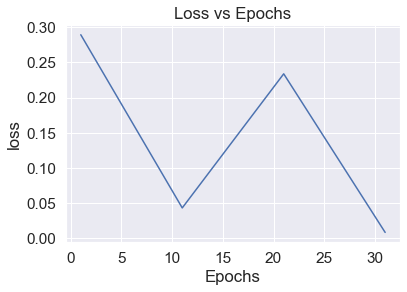

Final accuracy : 0.9453
Final accuracy : 0.8971
vascular_dementia
epoch 10	loss : 0.04714290797710419	 accuracy : 0.8189300411522634
epoch 20	loss : 0.016936220228672028	 accuracy : 0.823045267489712
epoch 30	loss : 0.006378085818141699	 accuracy : 0.8436213991769548
epoch 40	loss : 0.0935414582490921	 accuracy : 0.823045267489712


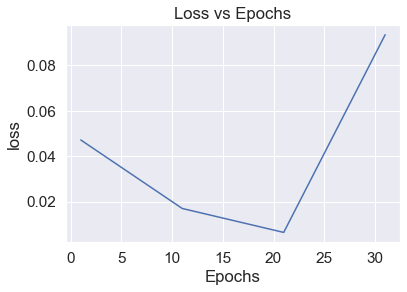

Final accuracy : 0.8751
Final accuracy : 0.8148
adhd
epoch 10	loss : 0.3633294403553009	 accuracy : 0.7654320987654321
epoch 20	loss : 0.05458047240972519	 accuracy : 0.8189300411522634
epoch 30	loss : 0.009899279102683067	 accuracy : 0.7777777777777778
epoch 40	loss : 0.00017412033048458397	 accuracy : 0.7695473251028807


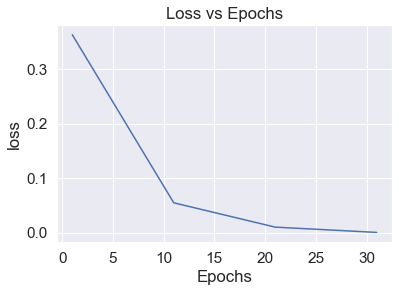

Final accuracy : 0.8421
Final accuracy : 0.7737
bipolar
epoch 10	loss : 0.15432335436344147	 accuracy : 0.6954732510288066
epoch 20	loss : 0.0555536225438118	 accuracy : 0.7530864197530864
epoch 30	loss : 0.008323043584823608	 accuracy : 0.7489711934156379
epoch 40	loss : 0.003375140018761158	 accuracy : 0.7530864197530864


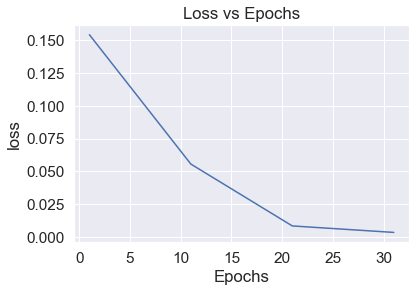

Final accuracy : 0.7647
Final accuracy : 0.7531


In [40]:
# MLP for each class with imbalanced classes
X_train, X_test, Y_train, Y_test = train_test_split(X_bal, Y_bal_multi, train_size=0.8, random_state = 0)
model = Net(input_shape=X_bal.shape[1])
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
for col in Y_bal_multi.columns:
    trainset = dataset(X_train,np.array(Y_train[col]).reshape(-1,1))
    trainloader = DataLoader(trainset,batch_size=8,shuffle=False)
    
    print(col)
    train_model(X_test, Y_test[col])
    train_acc = evaluate_model(X_train, Y_train[col])
    test_acc = evaluate_model(X_test, Y_test[col])
    df_results2 = df_results2.append({'output': col, 'bal_train': train_acc, 
                                     'bal_test': test_acc}, ignore_index=True)

In [41]:
df_results = pd.concat([df_results1,df_results2],axis=1)
df_results

,imb_test,imb_train,output,bal_test,bal_train,output
0,0.333333,0.374286,multi-output,0.425824,0.459906,multi-output
1,0.733333,0.786286,multi-output-mean,0.786264,0.788443,multi-output-mean
2,0.673333,0.822857,insomnia,0.740741,0.804954,insomnia
3,0.920000,0.948571,schizophrenia,0.897119,0.945304,schizophrenia
4,0.706667,0.911429,vascular_dementia,0.814815,0.875129,vascular_dementia
5,0.620000,0.797143,adhd,0.773663,0.842105,adhd
6,0.646667,0.797143,bipolar,0.753086,0.764706,bipolar


In [42]:
total_time = time.time() - start
print(f'Time elapsed: {total_time:.2} seconds')

Time elapsed: 2e+02 seconds
